# anatomix (ICLR'25) tutorial

#### [Paper link](https://arxiv.org/abs/2411.02372) | [GitHub link](https://github.com/neel-dey/anatomix)

In this tutorial, we'll cover how to:
1. Extract 3D features that are approximately stable to modality and appearance changes.
2. Use anatomix features for 3D multimodality registration and **reproduce** our Learn2Reg MRCT results.

If you want to *finetune* the pretrained model for your own datasets or tasks, check out [this tutorial](https://colab.research.google.com/drive/1WBslSRLgAAMq6o5YFif1y0kaW9Ac15XK?usp=sharing) instead.

# 1. 3D feature extraction using anatomix

In [8]:
!hostname

gl1012.arc-ts.umich.edu


In [9]:
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from glob import glob
import os
from tqdm import tqdm
import SimpleITK as sitk
import torchio as tio


In [10]:
from anatomix.model.network import Unet

In [11]:
ROOT = "/home/minsukc/MRI2CT/"
DATA_DIR_ROOT = "/scratch/jjparkcv_root/jjparkcv98/minsukc/"
OUTPUT_DIR = os.path.join(ROOT, "anatomix_outputs/")
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Load pretrained model and data and visualize data

In [12]:
# Instantiate model and load pretrained weights
model = Unet(
    dimension=3,  # Only 3D supported for now
    input_nc=1,  # number of input channels
    output_nc=16,  # number of output channels
    num_downs=4,  # number of downsampling layers
    ngf=16,  # channel multiplier
).cuda()

model.load_state_dict(
    torch.load(os.path.join(ROOT, "anatomix/model-weights/anatomix.pth")),
    strict=True,
)
model.eval()
print("Model loaded!")

Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Model loaded!


### Data preprocessing

In [ ]:
def show_middle_slices(vol1, vol2, title1="Original", title2="Cropped"):
    """Show middle axial slices from two 3D volumes for comparison."""
    # Get middle slice index for each volume
    z1 = vol1.shape[-1] // 2
    z2 = vol2.shape[-1] // 2

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.rot90(vol1[..., z1]), cmap="gray")
    plt.title(f"{title1} (z={z1})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.rot90(vol2[..., z2]), cmap="gray")
    plt.title(f"{title2} (z={z2})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [57]:
root = os.path.join(DATA_DIR_ROOT, "SynthRAD2025/Task1")

# Collect all mha paths first
mha_files = []
for anatomy in sorted(os.listdir(root)):  # AB, HN, TH
    anatomy_path = os.path.join(root, anatomy)
    if not os.path.isdir(anatomy_path):
        continue

    for patient in sorted(os.listdir(anatomy_path)):
        patient_path = os.path.join(anatomy_path, patient)
        if not os.path.isdir(patient_path):
            continue

        for name in ["mr.mha", "ct.mha", "mask.mha"]:
            mha_path = os.path.join(patient_path, name)
            if os.path.exists(mha_path):
                mha_files.append(mha_path)

print(f"🔍 Found {len(mha_files)} .mha files to check.")

# Convert with tqdm
for mha_path in tqdm(mha_files, desc="Converting .mha → .nii.gz"):
    nii_path = mha_path.replace(".mha", ".nii.gz")

    if not os.path.exists(nii_path):
        img = sitk.ReadImage(mha_path)
        sitk.WriteImage(img, nii_path)

🔍 Found 1539 .mha files to check.


Converting .mha → .nii.gz: 100%|██████████████████████████████████████████████████████████████████████| 1539/1539 [00:00<00:00, 1872.07it/s]


In [114]:
# data_dir = os.path.join(DATA_DIR_ROOT, "SynthRAD2025/Task1")
data_dir = os.path.join(DATA_DIR_ROOT, "SynthRAD2023/Task1")
print(data_dir)

# Collect MRI, CT, and mask paths
# mr_imgs, ct_imgs, mr_masks, ct_masks = [], [], [], []
mr_imgs, ct_imgs, masks = [], [], []

for anatomy in sorted(os.listdir(data_dir)):  # AB, HN, TH
    anatomy_path = os.path.join(data_dir, anatomy)
    if not os.path.isdir(anatomy_path):
        continue

    for patient in sorted(os.listdir(anatomy_path)):
        patient_path = os.path.join(anatomy_path, patient)
        if not os.path.isdir(patient_path):
            continue

        # mr_path = os.path.join(patient_path, "mr.mha")
        # ct_path = os.path.join(patient_path, "ct.mha")
        # mask_path = os.path.join(patient_path, "mask.mha")
        mr_path = os.path.join(patient_path, "mr.nii")
        ct_path = os.path.join(patient_path, "ct.nii")
        mask_path = os.path.join(patient_path, "mask.nii")
        # mr_path = os.path.join(patient_path, "mr.nii.gz")
        # ct_path = os.path.join(patient_path, "ct.nii.gz")
        # mask_path = os.path.join(patient_path, "mask.nii.gz")

        if os.path.exists(mr_path) and os.path.exists(ct_path):
            mr_imgs.append(mr_path)
            ct_imgs.append(ct_path)
            if os.path.exists(mask_path):
                masks.append(mask_path)
            else:
                masks.append(None)

print(f"✅ Found {len(mr_imgs)} subjects across all anatomies.")
print(f"Example MRI: {mr_imgs[0]}")
print(f"Example CT : {ct_imgs[0]}")

/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1
✅ Found 360 subjects across all anatomies.
Example MRI: /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/brain/1BA001/mr.nii
Example CT : /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/brain/1BA001/ct.nii


In [115]:
def crop_and_save_volume(
    mri_path, ct_path, mask_path=None, out_dir=OUTPUT_DIR, target_shape=(128, 128, 128)
):
    subject = tio.Subject(
        mri=tio.ScalarImage(mri_path),
        ct=tio.ScalarImage(ct_path),
        mask=tio.LabelMap(mask_path) if mask_path else None,
    )

    # Center crop/pad to 128³
    print("Original shape:", subject.mri.shape)
    print("Original shape:", subject.ct.shape)
    transform = tio.CropOrPad(target_shape)
    # 192x160x192 Learn2Reg MRCT (Abdomen MR–CT)
    cropped = transform(subject)
    # ---- Visualization ----
    orig_mri = subject.mri.data.squeeze().numpy()
    crop_mri = cropped.mri.data.squeeze().numpy()
    show_middle_slices(orig_mri, crop_mri, "Original MRI", "Cropped MRI")

    orig_ct = subject.ct.data.squeeze().numpy()
    crop_ct = cropped.ct.data.squeeze().numpy()
    show_middle_slices(orig_ct, crop_ct, "Original CT", "Cropped CT")

    # Save to new folder
    patient_id = os.path.basename(os.path.dirname(mri_path))
    id = f"{patient_id}_{target_shape[0]}x{target_shape[1]}x{target_shape[2]}"
    patient_dir = os.path.join(out_dir, id)
    os.makedirs(patient_dir, exist_ok=True)

    cropped.mri.save(os.path.join(patient_dir, "mr.nii.gz"))
    cropped.ct.save(os.path.join(patient_dir, "ct.nii.gz"))
    if mask_path:
        cropped.mask.save(os.path.join(patient_dir, "mask.nii.gz"))
    return id

In [120]:
idx = 100
# target_shape = (128, 128, 128)
target_shape = (256, 256, 128)
print(ct_imgs[idx])

/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/brain/1BB098/ct.nii


Original shape: (1, 203, 227, 170)
Original shape: (1, 203, 227, 170)


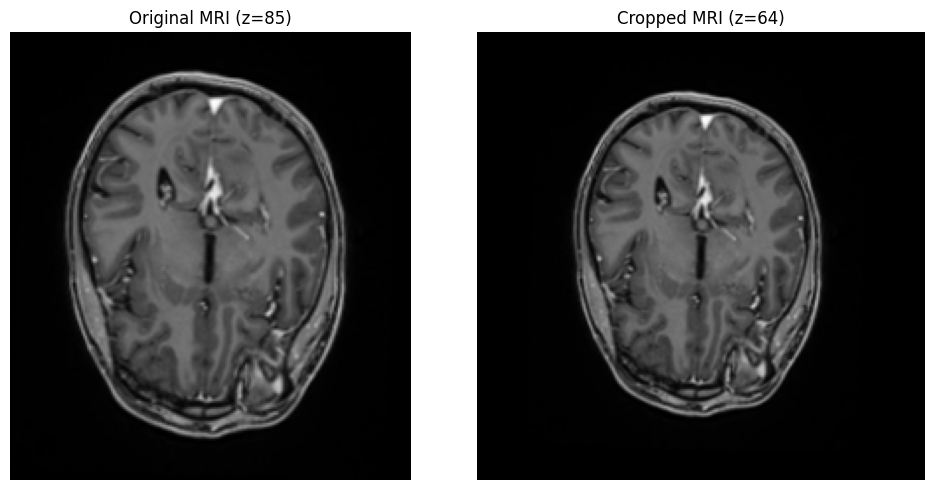

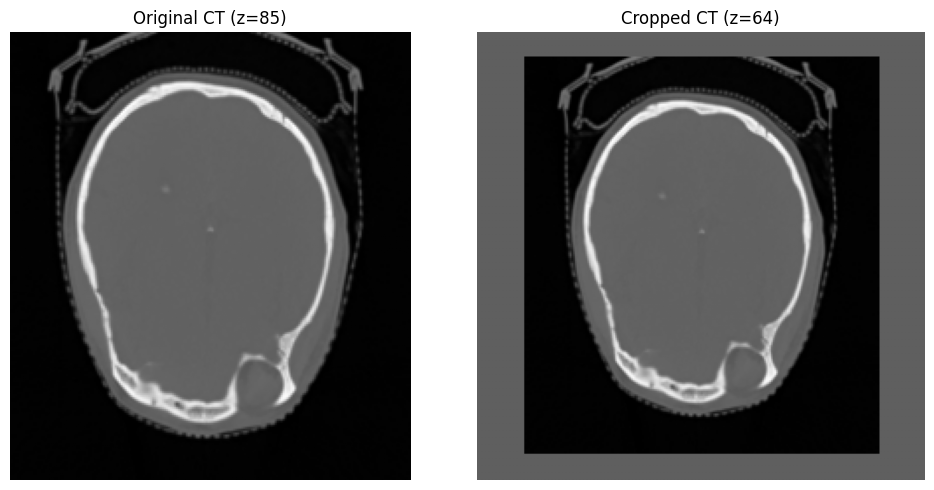

In [121]:
id = crop_and_save_volume(
    mr_imgs[idx], ct_imgs[idx], masks[idx], target_shape=target_shape
)

In [122]:
# subject_id = mr_imgs[idx].split("/")[-2] + "_unregistered"
target_dir = os.path.join(OUTPUT_DIR, id)
mr_img = os.path.join(target_dir, "mr.nii.gz")
ct_img = os.path.join(target_dir, "ct.nii.gz")
mask = os.path.join(target_dir, "mask.nii.gz")

In [123]:
def minmax(arr, minclip=None, maxclip=None):
    if not (minclip is None) & (maxclip is None):
        arr = np.clip(arr, minclip, maxclip)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr


# MRI
# mri_img = sitk.ReadImage(mr_imgs[0])
# mri = sitk.GetArrayFromImage(mri_img)
# mri = np.transpose(mri, (1, 0, 2))  # to match nibabel orientation
mri = nib.load(mr_img).get_fdata()
mri = minmax(mri)

# CT
# ct_img = sitk.ReadImage(ct_imgs[0])
# ct = sitk.GetArrayFromImage(ct_img)
# ct = np.transpose(ct, (1, 0, 2))  # to match nibabel orientation
ct = nib.load(ct_img).get_fdata()
ct = minmax(ct, minclip=-450, maxclip=450)
print(mri.shape)
print(ct.shape)

(256, 256, 128)
(256, 256, 128)


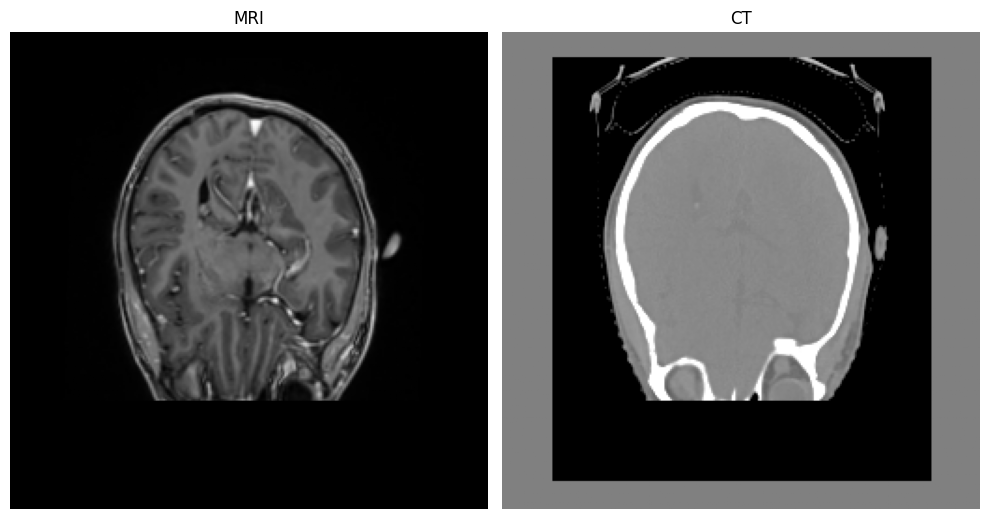

/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/brain/1BB098/ct.nii


In [124]:
sliceidx = 60

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
# plt.imshow(np.rot90(mri[sliceidx, :, :]), cmap="gray")  # Axial view
plt.imshow(np.rot90(mri[:, :, sliceidx]), cmap="gray")  # Axial view
plt.title("MRI")
plt.axis("off")

plt.subplot(1, 2, 2)
# plt.imshow(np.rot90(ct[sliceidx, :, :]), cmap="gray")  # Axial view
plt.imshow(np.rot90(ct[:, :, sliceidx]), cmap="gray")  # Axial view
plt.title("CT")
plt.axis("off")

plt.tight_layout()
plt.show()
print(ct_imgs[idx])

### Extract invariant features and visualize outputs

In [125]:
import torch.nn.functional as F


# def pad_to_multiple(tensor, multiple=16):
#     """Pad tensor [B, C, D, H, W] so each spatial dim is a multiple of `multiple`."""
#     _, _, D, H, W = tensor.shape
#     pad_D = (multiple - D % multiple) % multiple
#     pad_H = (multiple - H % multiple) % multiple
#     pad_W = (multiple - W % multiple) % multiple
#     pad = (0, pad_W, 0, pad_H, 0, pad_D)
#     tensor_padded = F.pad(tensor, pad, mode="constant", value=0)
#     pad_width = ((0, pad_D), (0, pad_H), (0, pad_W))
#     return tensor_padded, pad_width


# def unpad_tensor(tensor, pad_width):
#     """Crop a padded tensor [B, C, D, H, W] back to its original size."""
#     d_pad, h_pad, w_pad = pad_width
#     d_end = None if d_pad[1] == 0 else -d_pad[1]
#     h_end = None if h_pad[1] == 0 else -h_pad[1]
#     w_end = None if w_pad[1] == 0 else -w_pad[1]
#     return tensor[..., 0:d_end, 0:h_end, 0:w_end]


# Extract 3D features:
with torch.no_grad():
    mri_inp = torch.from_numpy(mri[None, None]).float().cuda()
    # mri_inp, mri_pad = pad_to_multiple(mri_inp, multiple=16)
    mri_feats = model(mri_inp)
    # mri_feats = unpad_tensor(mri_feats, mri_pad)

    ct_inp = torch.from_numpy(ct[None, None]).float().cuda()
    # ct_inp, ct_pad = pad_to_multiple(ct_inp, multiple=16)
    ct_feats = model(ct_inp)
    # ct_feats = unpad_tensor(ct_feats, ct_pad)


# The pretrained network produces outputs with 16 channels:
print(f"Output MRI features shape: {mri_feats.shape}")
print(f"Output CT features shape: {ct_feats.shape}")

Output MRI features shape: torch.Size([1, 16, 256, 256, 128])
Output CT features shape: torch.Size([1, 16, 256, 256, 128])


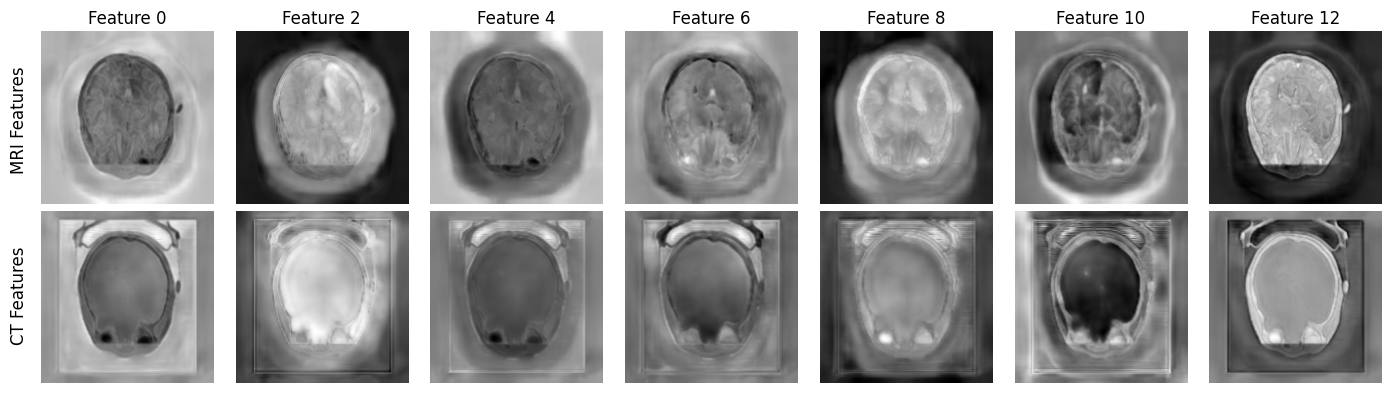

In [126]:
sliceidx = 60

plt.figure(figsize=(14, 4))

# Add row titles
plt.text(-0.02, 0.75, "MRI Features", fontsize=12, va="center", rotation=90)
plt.text(-0.02, 0.25, "CT Features", fontsize=12, va="center", rotation=90)
plt.axis("off")

# Visualize a subset of all channels
# MRI outputs
for i in range(7):
    plt.subplot(2, 7, i + 1)
    plt.imshow(
        np.rot90(mri_feats[0, i * 2, :, :, sliceidx].cpu().numpy()),
        cmap="gray",
    )
    plt.axis("off")
    plt.title(f"Feature {i * 2}")

# CT outputs
for i in range(7):
    plt.subplot(2, 7, 7 + (i + 1))
    plt.imshow(
        np.rot90(ct_feats[0, i * 2, :, :, sliceidx].cpu().numpy()),
        cmap="gray",
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

# 2. Multimodality registration using anatomix

We're going to do intrasubject registration on Learn2RegMRCT by registering the MRIs to the CTs.

In [127]:
# Load registration module
# We use a heavily modified fork of the convexadam repository as our solver here
from anatomix.registration import convex_adam

**NOTE FOR OTHER DATASETS**: The convexadam solver requires careful tuning of registration hyperparameters. The settings here were found via grid search on Subject 1 (index 0) of this dataset (our validation subject). It is likely that your own dataset will require other convexadam hyperparameters.

### Grid search for convexadam hyperparameters

In [128]:
# # Output folder for temporary registrations
# os.makedirs("./tune_results", exist_ok=True)

# # Parameter search ranges
# lambda_candidates = [0.25, 0.5, 0.75, 1.0]
# grid_sp_candidates = [1, 2, 4]
# smooth_candidates = [0, 1, 2]


# # ----------------------------
# # EVALUATION FUNCTION
# # ----------------------------
# def compute_dice(gt_path, pred_path):
#     """Compute Dice score between ground-truth and predicted label volumes."""
#     gt = nib.load(gt_path).get_fdata()
#     pred = nib.load(pred_path).get_fdata()
#     gt = gt.astype(np.uint8).flatten()
#     pred = pred.astype(np.uint8).flatten()
#     labels = np.unique(gt)[1:]  # ignore background (0)
#     return f1_score(gt, pred, average="macro", labels=labels)


# # ----------------------------
# # GRID SEARCH LOOP
# # ----------------------------
# results = []

# for lam in lambda_candidates:
#     for grid in grid_sp_candidates:
#         for sm in smooth_candidates:
#             expname = f"lam{lam}_grid{grid}_sm{sm}"
#             print(f"\n🔹 Running registration: {expname}")

#             convex_adam(
#                 ckpt_path="./anatomix/model-weights/anatomix.pth",
#                 expname=expname,
#                 result_path="./tune_results/",
#                 lambda_weight=lam,
#                 grid_sp=grid,
#                 disp_hw=1,
#                 selected_niter=80,
#                 selected_smooth=sm,
#                 grid_sp_adam=grid,
#                 ic=True,
#                 use_mask=True,
#                 warp_seg=True,
#                 fixed_image=fixed_ct,
#                 fixed_mask=fixed_mask,
#                 fixed_seg=fixed_label,
#                 fixed_minclip=-450,
#                 fixed_maxclip=450,
#                 moving_image=moving_mr,
#                 moving_mask=moving_mask,
#                 moving_seg=moving_label,
#             )

#             # Compute Dice score
#             pred_label_path = f"./tune_results/{expname}/labels_moved_{os.path.basename(moving_label)}"
#             if os.path.exists(pred_label_path):
#                 dice = compute_dice(fixed_label, pred_label_path)
#             else:
#                 dice = 0.0

#             print(f"   → Dice: {dice:.4f}")
#             results.append((lam, grid, sm, dice))

# # ----------------------------
# # 4️⃣ SUMMARIZE RESULTS
# # ----------------------------

# results = sorted(results, key=lambda x: x[-1], reverse=True)
# print("\n🏁 Grid Search Completed!")
# print("Top results:")
# for lam, grid, sm, dice in results[:5]:
#     print(f"λ={lam}, grid_sp={grid}, smooth={sm} → Dice={dice:.4f}")

# best = results[0]
# print(
#     f"\n✅ Best Parameters → λ={best[0]}, grid_sp={best[1]}, smooth={best[2]} (Dice={best[3]:.4f})"
# )


### Reproduce results

#### Compute registrations

In [129]:
# Create scratch output directory
os.makedirs("./demo", exist_ok=True)

# Loop over all subjects and save outputs to disk:
# for i in range(8):
convex_adam(
    ckpt_path=os.path.join(ROOT, "./anatomix/model-weights/anatomix.pth"),
    expname="demo",
    # result_path="./demo/",
    result_path=target_dir,
    lambda_weight=0.75,
    grid_sp=2,
    disp_hw=1,
    selected_niter=80,
    selected_smooth=0,
    grid_sp_adam=2,
    ic=True,
    use_mask=True,
    # warp_seg=True,
    warp_seg=False,
    fixed_image=ct_img,
    fixed_mask=mask,
    # fixed_seg=ct_labels[i],
    fixed_minclip=-450,
    fixed_maxclip=450,
    moving_image=mr_img,
    moving_mask=mask,
    # moving_seg=mr_labels[i],
)

Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  0.9244885444641113


#### Compute test set results

In [130]:
# predictions = sorted(glob("./demo/labels_moved*.nii.gz"))
# gts = sorted(glob("./AbdomenMRCT/labelsTr/*_0001.nii.gz"))[:8]

# assert len(predictions) == len(gts)

# # Compute test set results:
# dices = np.zeros(len(predictions))

# for i in range(len(predictions)):
#     pred = nib.load(predictions[i]).get_fdata()
#     gt = nib.load(gts[i]).get_fdata()
#     dices[i] = f1_score(
#         y_true=gt.flatten().astype(np.uint8),
#         y_pred=pred.flatten().astype(np.uint8),
#         average="macro",
#         labels=np.unique(gt.flatten())[1:],
#     )

# # In our paper, we tuned the hyperparameters on subject 1 and tested on the
# # remaining seven
# print(f"Test set median Dice: {np.median(dices[1:])}")

#### Visualize registration results

In [131]:
def load_nifti_for_viz(fpath):
    nii = nib.load(fpath)
    arr = nii.get_fdata().squeeze()
    return arr


# Sample arbitrary subject index
# subj_idx = 5

# Load input fixed and moving volumes
# fixed_ct = load_nifti_for_viz(ct_imgs[subj_idx])
fixed_ct = load_nifti_for_viz(ct_img)
fixed_ct = minmax(fixed_ct, minclip=-450, maxclip=450)

# moving_mr = load_nifti_for_viz(mr_imgs[subj_idx])
moving_mr = load_nifti_for_viz(mr_img)
moving_mr = minmax(moving_mr)

# Load computed moved mri and displacement field
moved_imgs = sorted(glob(os.path.join(target_dir, "moved*.nii.gz")))
moved_mr = load_nifti_for_viz(moved_imgs[0])
moved_mr = minmax(moved_mr)

moved_disp = sorted(glob(os.path.join(target_dir, "disp*.nii.gz")))
moved_disp = load_nifti_for_viz(moved_disp[0])
# Displacement field's a (x, y, z, 3) array, we use its norm for viz
moved_disp = minmax(np.linalg.norm(moved_disp, axis=-1))

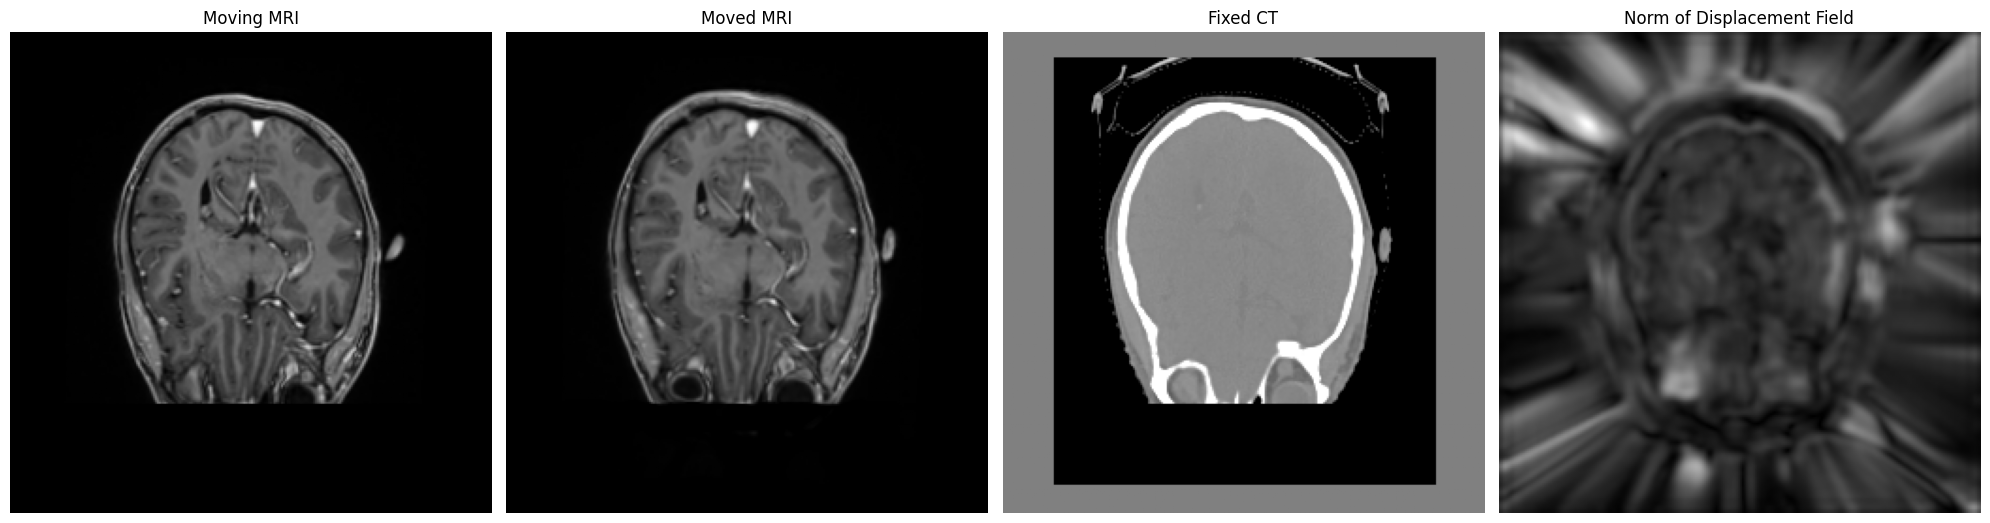

In [132]:
# Visualize a coronal slice from Subject 1

sliceidx = 60

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.rot90(moving_mr[:, :, sliceidx]), cmap="gray")
plt.title("Moving MRI")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(np.rot90(moved_mr[:, :, sliceidx]), cmap="gray")
plt.title("Moved MRI")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(np.rot90(fixed_ct[:, :, sliceidx]), cmap="gray")
plt.title("Fixed CT")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(np.rot90(moved_disp[:, :, sliceidx]), cmap="gray")
plt.title("Norm of Displacement Field")
plt.axis("off")
plt.tight_layout()
plt.show()


### CLI interface

If you want to use anatomix with convexadam from the command line, you can provide input volume niftis as below.

Use `!python anatomix/anatomix/registration/run_convex_adam_with_network_feats.py -h` to see the full CLI interface.

In [ ]:
# # Create scratch output directory
# os.makedirs("./cli_demo/", exist_ok=True)

# !python anatomix/anatomix/registration/run_convex_adam_with_network_feats.py \
# --ckpt_path ./anatomix/model-weights/anatomix.pth \
# --exp_name withmask \
# --fixed_minclip -450 \
# --fixed_maxclip 450 \
# --use_mask \
# --result_path ./cli_demo/ \
# --warp_seg \
# --fixed /content/AbdomenMRCT/imagesTr/AbdomenMRCT_0001_0001.nii.gz \
# --moving /content/AbdomenMRCT/imagesTr/AbdomenMRCT_0001_0000.nii.gz \
# --path_mask_fixed /content/AbdomenMRCT/masksTr/AbdomenMRCT_0001_0001.nii.gz \
# --path_mask_moving /content/AbdomenMRCT/masksTr/AbdomenMRCT_0001_0000.nii.gz \
# --path_seg_fixed /content/AbdomenMRCT/labelsTr/AbdomenMRCT_0001_0001.nii.gz \
# --path_seg_moving /content/AbdomenMRCT/labelsTr/AbdomenMRCT_0001_0000.nii.gz

2025-01-20 22:34:27.777828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 22:34:27.797945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 22:34:27.804160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 22:34:29.079823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading model
Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
Running network on input images
case time:  1.928328275680542
Dice: 0.8758862828964441
